# Training Strategy 1: Random Test/Train Split

In [42]:
import pandas as pd
weather_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/weather_data_cleaned.csv')
crowd_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/sensor_data.csv')
crowd_df['timestamp'] = pd.to_datetime(crowd_df['timestamp'], utc=False)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=False)
weather_df = weather_df.rename(columns={'datetime': 'timestamp'})
weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)
crowd_df['timestamp'] = crowd_df['timestamp'].dt.tz_localize(None)

merged_df = pd.merge_asof(
    crowd_df,
    weather_df,
    on = 'timestamp',
    direction = 'nearest',
    tolerance = pd.Timedelta('60min')
)

merged_df = merged_df.set_index('timestamp')
merged_df.head()

,CMSA-GAKH-01_0,CMSA-GAKH-01_180,CMSA-GAWW-11_120,CMSA-GAWW-11_300,CMSA-GAWW-12_115,CMSA-GAWW-12_295,CMSA-GAWW-13_120,CMSA-GAWW-13_300,CMSA-GAWW-14_40,CMSA-GAWW-14_220,...,weekday,is_weekend,temperature,dew_point,air_pressure,wind_speed,max_gust,rainfall,sunshine_duration,relative_humidity
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-08-20 00:00:00,15,4,29,33,44,28,42,37,11,3,...,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
2025-08-20 00:03:00,1,3,21,29,34,39,9,14,6,6,...,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
2025-08-20 00:06:00,5,4,35,22,29,34,33,42,14,3,...,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
2025-08-20 00:09:00,4,4,40,47,42,40,19,34,15,2,...,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75
2025-08-20 00:12:00,4,11,54,59,58,33,17,33,26,9,...,2,0,16.8,12.5,1014.6,4.0,7.0,0.0,0.0,75


In [43]:
merged_df.to_csv(
    '/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/crowd_weather_merged.csv', index = True
)

In [44]:
sensor_cols = merged_df.columns[1:-14]
feature_cols = merged_df.columns[-14:]


In [45]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import xgboost as xgb
import os 

xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'objective': 'reg:squarederror',
    'random_state': 43,
    'verbosity': 0,
    'n_jobs': -1
}

OUT_DIR = '/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb' # Output directory to store models 
os.makedirs(OUT_DIR, exist_ok=True)

X_train, X_test = train_test_split(merged_df[feature_cols], test_size=0.2, random_state=42)

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, 'scaler.joblib')) # save scaler used


models = {} # dictionary to store models
mae_per_sensor = [] # mean absolute error
r2_per_sensor = [] # r2 score

results ={}


for i, sensor in enumerate(sensor_cols):
    print(f"\nTraining sensor {i+1}/{len(sensor_cols)}: {sensor}")
    
    y_train = merged_df.loc[X_train.index, sensor]
    y_test = merged_df.loc[X_test.index, sensor]

    # Train model
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    # Predict on test
    y_pred = model.predict(X_test_scaled)

    # Save model
    model_path = os.path.join(OUT_DIR, f'xgb_{sensor.replace("/", "_")}.joblib')
    joblib.dump(model, model_path)
    models[sensor] = model

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store for later
    results[sensor] = {
        "model": model,
        "y_test": y_test,
        "y_pred": y_pred,
        "mae": mae,
        "r2": r2
    }
    mae_per_sensor.append(mae)
    r2_per_sensor.append(r2)

    print(f"Saved {model_path}  MAE={mae:.3f}, R2={r2:.3f}")


Training sensor 1/73: CMSA-GAKH-01_180
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb/xgb_CMSA-GAKH-01_180.joblib  MAE=12.834, R2=0.875

Training sensor 2/73: CMSA-GAWW-11_120
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb/xgb_CMSA-GAWW-11_120.joblib  MAE=11.731, R2=0.809

Training sensor 3/73: CMSA-GAWW-11_300
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb/xgb_CMSA-GAWW-11_300.joblib  MAE=11.438, R2=0.765

Training sensor 4/73: CMSA-GAWW-12_115
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb/xgb_CMSA-GAWW-12_115.joblib  MAE=11.751, R2=0.753

Training sensor 5/73: CMSA-GAWW-12_295
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_1_models_xgb/xgb_CMSA-GAWW-12_295.joblib  MAE=12.019, R2=0.823

Training sensor 6/73: CMSA-GAWW-13_120
Saved /Users/sheikharfahmi/Desktop/TIL_Python


📈 Model Performance Summary:
              Sensor     MAE     R2
38       GASA-03_285  23.648  0.899
37       GASA-03_105  23.467  0.896
35    GASA-02-02_135  29.810  0.889
34    GASA-02-01_315  24.571  0.886
0   CMSA-GAKH-01_180  12.834  0.875
..               ...     ...    ...
63        GVCV-08_45   8.097 -0.634
58     GVCV-05-B_210  37.996 -0.678
45        GASA-06_95   0.004 -0.899
64       GVCV-08_225   5.619 -1.122
46       GASA-06_275   0.015 -1.636

[73 rows x 3 columns]


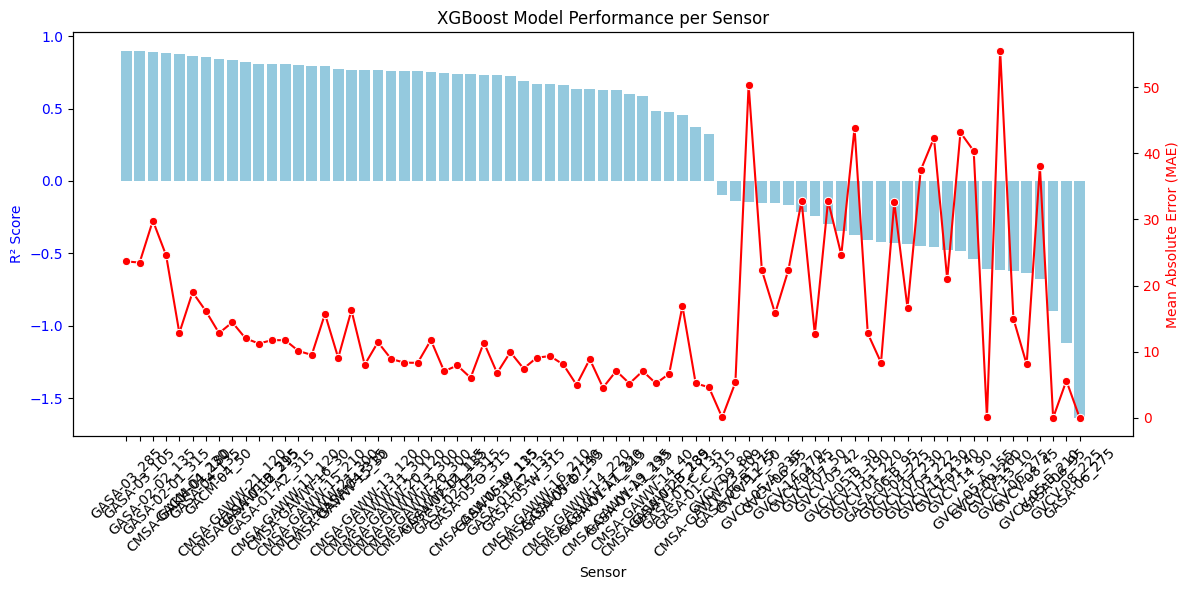

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect results into a DataFrame
results_df = pd.DataFrame({
    'Sensor': sensor_cols,
    'MAE': mae_per_sensor,
    'R2': r2_per_sensor
}).sort_values('R2', ascending=False)

# Print a summary table
print("\n📈 Model Performance Summary:")
print(results_df.round(3))

# Plot MAE and R2 for each sensor
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: R2 scores
sns.barplot(x='Sensor', y='R2', data=results_df, color='skyblue', ax=ax1)
ax1.set_ylabel('R² Score', color='blue')
ax1.set_xlabel('Sensor')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Right y-axis: MAE values
ax2 = ax1.twinx()
sns.lineplot(x='Sensor', y='MAE', data=results_df, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Mean Absolute Error (MAE)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('XGBoost Model Performance per Sensor')
plt.tight_layout()
plt.show()


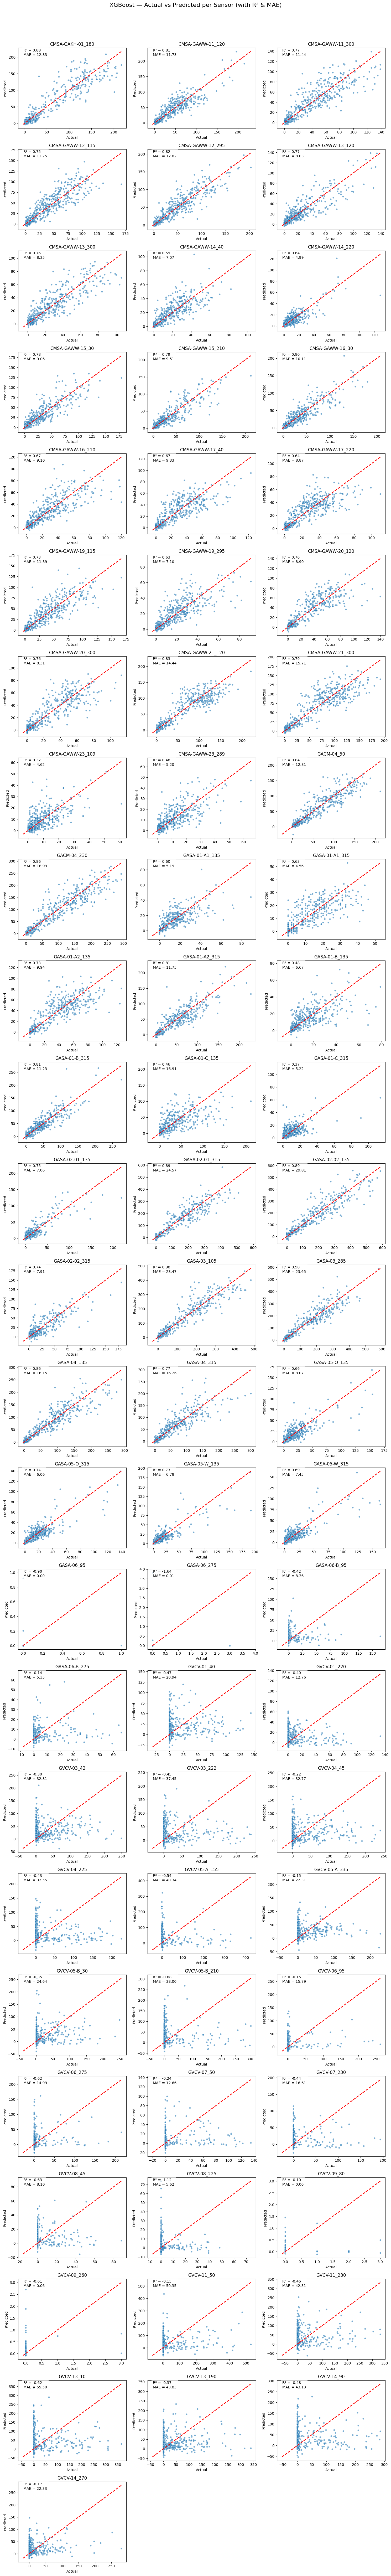

In [47]:
plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)

    res = results[sensor]
    y_test = res["y_test"]
    y_pred = res["y_pred"]

    sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.6)

    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)

    plt.text(
        0.05, 0.90,
        f"R² = {res['r2']:.2f}\nMAE = {res['mae']:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

    plt.title(sensor)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

plt.suptitle("XGBoost — Actual vs Predicted per Sensor (with R² & MAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70849/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70849/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70849/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70849/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

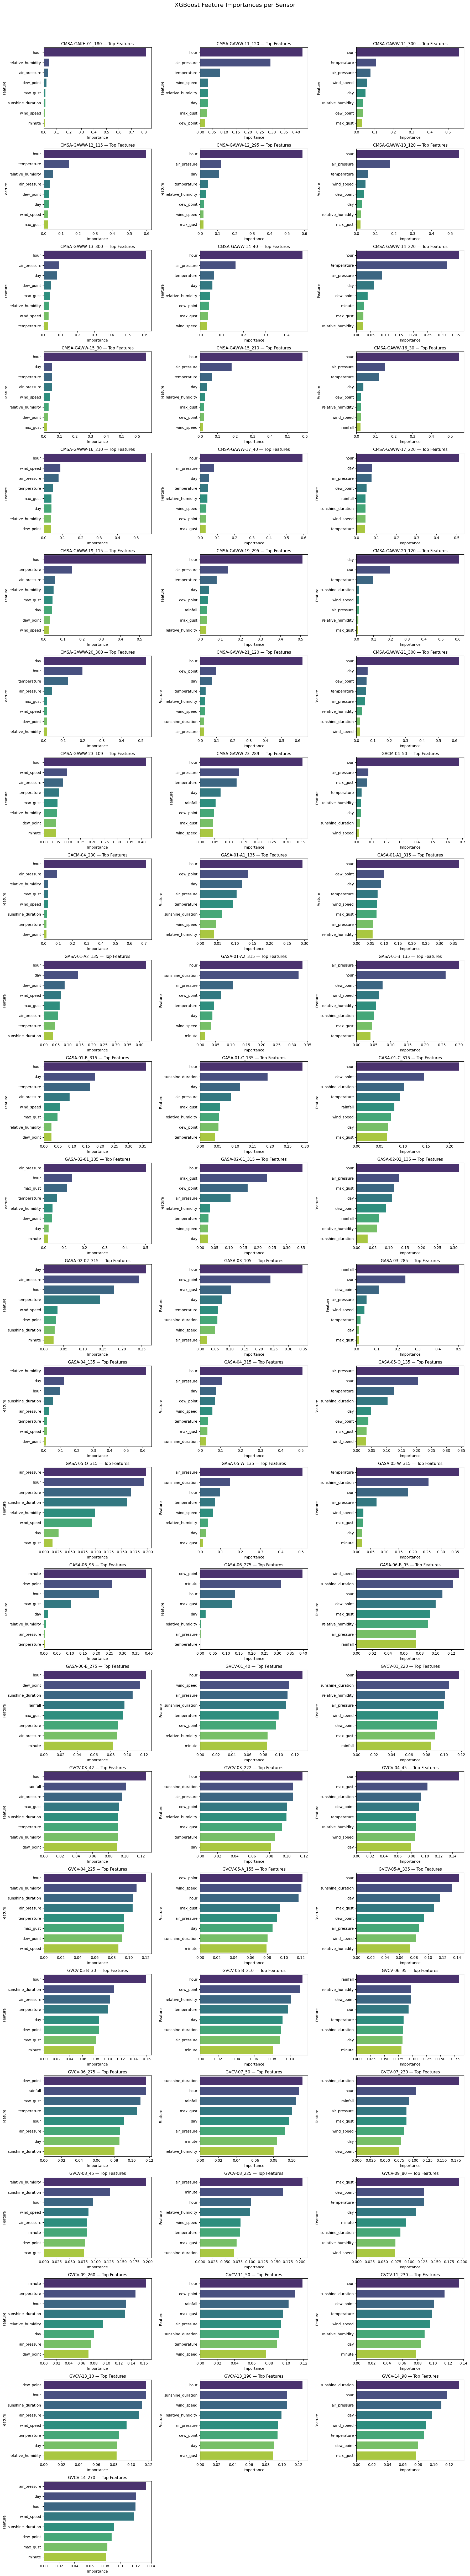

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Create subplots
n_sensors = len(sensor_cols)
n_cols = 3
n_rows = int(np.ceil(n_sensors / n_cols))

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    model = models[sensor]
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances,
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(
        data=importance_df.head(8),  # top 8 features
        x='Importance', y='Feature', palette='viridis'
    )
    
    plt.title(f"{sensor} — Top Features", fontsize=11)
    plt.xlabel("Importance")
    plt.ylabel("Feature")

plt.suptitle("XGBoost Feature Importances per Sensor", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
